# 1. Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import string
import re
from collections import Counter
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# 2. Data Loading

In [4]:
data = pd.read_csv('fake_reviews_dataset.csv')
data['text_'] = data['text_'].astype(str)

# 3. Data Exploration

In [5]:
data.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [7]:
data.groupby('category')['rating'].mean()

category
Books_5                         4.254691
Clothing_Shoes_and_Jewelry_5    4.172817
Electronics_5                   4.167503
Home_and_Kitchen_5              4.246795
Kindle_Store_5                  4.373996
Movies_and_TV_5                 4.148272
Pet_Supplies_5                  4.209685
Sports_and_Outdoors_5           4.316776
Tools_and_Home_Improvement_5    4.306117
Toys_and_Games_5                4.343437
Name: rating, dtype: float64

In [8]:
data['rating'].value_counts()

rating
5.0    24559
4.0     7965
3.0     3786
1.0     2155
2.0     1967
Name: count, dtype: int64

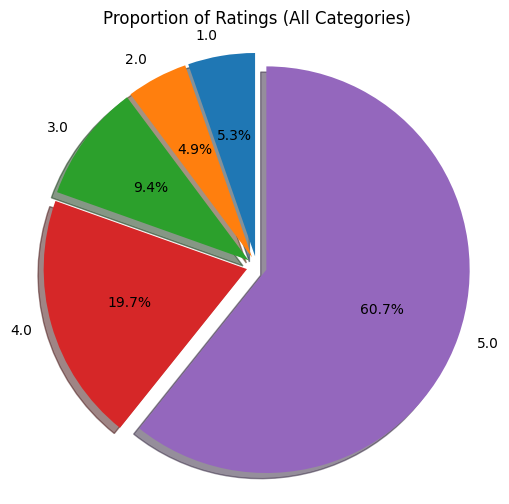

In [9]:
rating_counts = data['rating'].value_counts().sort_index()

explode = [0.05] * len(rating_counts) 

plt.figure(figsize=(6, 6))
plt.pie(
    rating_counts,
    labels=rating_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode,
    shadow=True 
)
plt.title('Proportion of Ratings (All Categories)')
plt.axis('equal')
plt.show()

C:\Users\rk\AppData\Local\Temp\ipykernel_17208\1748746896.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='label', palette='Set2')


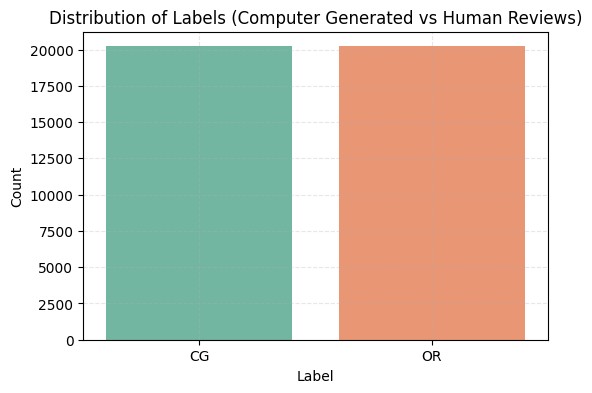

In [10]:
plt.figure(figsize=(6,4))
sns.countplot(data=data, x='label', palette='Set2')
plt.title("Distribution of Labels (Computer Generated vs Human Reviews)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

# 4. Data Preprocessing

In [11]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [12]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    tokens = word_tokenize(text)

    cleaned = []
    for word in tokens:
        word = word.translate(str.maketrans('', '', string.punctuation))
        if word.isalpha() and word not in stop_words:
            lemma = lemmatizer.lemmatize(word)
            cleaned.append(lemma)

    return ' '.join(cleaned)

In [13]:
data['clean_text'] = data['text_'].apply(preprocess)

In [14]:
data.head(15)

,category,rating,label,text_,clean_text
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",love well made sturdy comfortable love pretty
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",love great upgrade original mine couple year
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,pillow saved back love look feel pillow
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",missing information use great product price
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,nice set good quality set two month
5,Home_and_Kitchen_5,3.0,CG,I WANTED DIFFERENT FLAVORS BUT THEY ARE NOT.,wanted different flavor
6,Home_and_Kitchen_5,5.0,CG,They are the perfect touch for me and the only...,perfect touch thing wish little space
7,Home_and_Kitchen_5,3.0,CG,These done fit well and look great. I love th...,done fit well look great love smoothness edge ...
8,Home_and_Kitchen_5,5.0,CG,"Great big numbers & easy to read, the only thi...",great big number easy read thing nt like size
9,Home_and_Kitchen_5,5.0,CG,My son loves this comforter and it is very wel...,son love comforter well made also baby


In [15]:
data = data.drop(columns=['text_'])

# 5. EDA on Cleaned Text

In [16]:
data['length'] = data['clean_text'].apply(len)

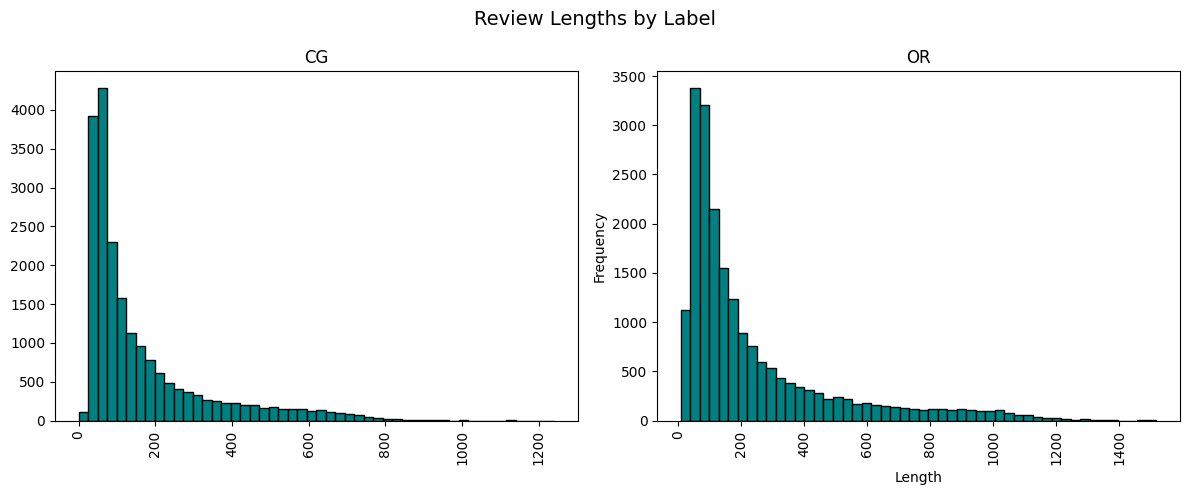

In [17]:
data.hist(column='length', by='label', bins=50, figsize=(12, 5), color='teal', edgecolor='black')
plt.suptitle("Review Lengths by Label", fontsize=14)
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [18]:
longest_or = data[data['label'] == 'OR'].sort_values(by='length', ascending=False).iloc[0]
print("\nLongest Human (Original) Review:\n")
print(longest_or['clean_text'])
print("Length:", longest_or['length'])
print("Label: OR (Human Original Review)")

longest_cg = data[data['label'] == 'CG'].sort_values(by='length', ascending=False).iloc[0]
print("\nLongest Computer Generated (CG) Review:\n")
print(longest_cg['clean_text'])
print("Length:", longest_cg['length'])
print("Label: CG (Computer Generated Review)")



Longest Human (Original) Review:

tony randall star success spoil rock hunter opposite jayne mansfield hair bleached white magistrate wig jayne seems poor marilyn monroe caricature whose tendency squeak prance bubble downright annoying example ad man rock brag new business venture right sweetie president rita marlowe production inc miss marlowe titular head word brings loud squeal mansfield sound like bus trying slow brake pad story open great promise demonstration cinemascope stereo sound tony randall stand extreme stage left identifies movie see girl ca nt help vhs nbsp dvd previous jayne effort starred tom ewell appeared superior monroe another fox feature seven year itch nbsp vhs dvd although tony quite good better fact ewell opposite monroe ca nt carry load jayne incoherent boyfriend mickey hargitay weighing however lot clever bit simulated commercial clip calypso song enough bustle even chaos hold attention cameo uncrediteds groucho marx eyebrowwagging best star trek majel barre

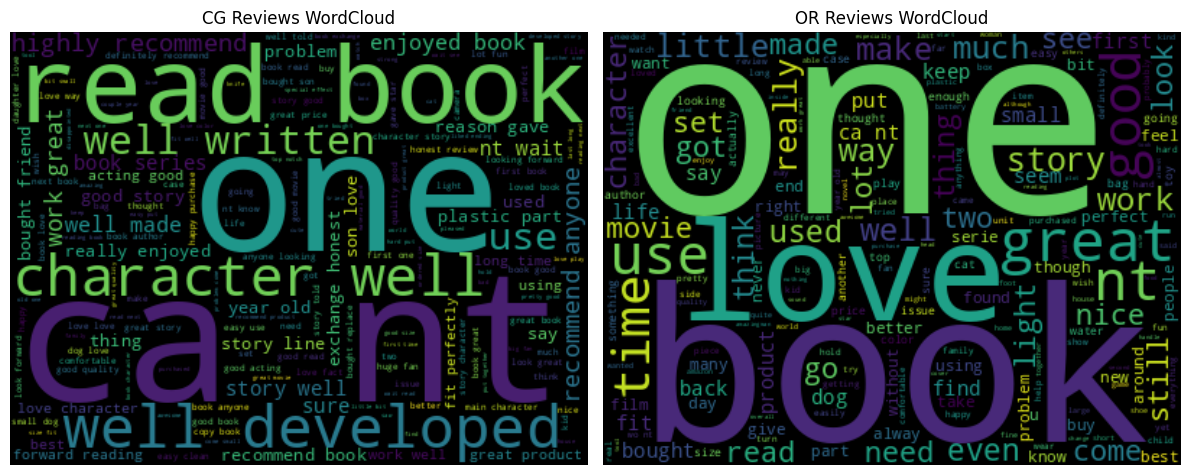

In [19]:
cg_text = " ".join(data[data['label'] == 'CG']['clean_text'])
or_text = " ".join(data[data['label'] == 'OR']['clean_text'])
wc_cg = WordCloud(width=400, height=300).generate(cg_text)
wc_or = WordCloud(width=400, height=300).generate(or_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(wc_cg, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('CG Reviews WordCloud')

axes[1].imshow(wc_or, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('OR Reviews WordCloud')

plt.tight_layout()
plt.show()

# 6. Feature Extraction and Vectorization

In [20]:
bow_transformer = CountVectorizer() 
bow_transformer.fit(data['clean_text'])
print("Total Vocabulary:", len(bow_transformer.vocabulary_))

Total Vocabulary: 39601


In [21]:
bow_reviews = bow_transformer.transform(data['clean_text'])
print("BoW matrix shape:", bow_reviews.shape)
print("Number of non-zero elements:", bow_reviews.nnz)

BoW matrix shape: (40432, 39601)
Number of non-zero elements: 1009879


In [22]:
sparsity = (bow_reviews.nnz / (bow_reviews.shape[0] * bow_reviews.shape[1])) * 100
print(f"Sparsity: {np.round(sparsity, 2)}%")

Sparsity: 0.06%


In [23]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("TF-IDF matrix shape:", tfidf_reviews.shape)

TF-IDF matrix shape: (40432, 39601)


In [24]:
review_vec = bow_transformer.transform([data['clean_text'][3]])
tfidf_vec = tfidf_transformer.transform(review_vec)
print(tfidf_vec)

print("IDF for 'mango':", tfidf_transformer.idf_[bow_transformer.vocabulary_['mango']])


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6 stored elements and shape (1, 39601)>
  Coords	Values
  (0, 37197)	0.29637708804772994
  (0, 26865)	0.31686695519477687
  (0, 26708)	0.33625672844420584
  (0, 21959)	0.5938229470034856
  (0, 17213)	0.5495096257783145
  (0, 14634)	0.2100020136832301
IDF for 'mango': 10.914254381647021


# 7. Train and Test Data Split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['label'], test_size=0.35)

# 8. Model Training and Evaluation

In [26]:
model_accuracies = {}

def evaluate_text_classifier(model, X_train, y_train, X_test, y_test, accuracy_dict):
    pipeline = Pipeline([
        ('bow', CountVectorizer()), 
        ('tfidf', TfidfTransformer()),                    
        ('classifier', model)                   
    ])
    
    pipeline.fit(X_train, y_train)
    predictions = pipeline.predict(X_test)

    acc = accuracy_score(y_test, predictions)
    model_name = model.__class__.__name__
    accuracy_dict[model_name] = acc

    print(f"\nEvaluation for: {model_name}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print("\nClassification Report:")
    print(classification_report(y_test, predictions))
    print(f"Accuracy Score: {acc:.4f}")

## 8.1 Multinomial Naive Bayes

In [27]:
evaluate_text_classifier(MultinomialNB(), X_train, y_train, X_test, y_test, model_accuracies)


Evaluation for: MultinomialNB
Confusion Matrix:
[[6358  690]
 [1436 5668]]

Classification Report:
              precision    recall  f1-score   support

          CG       0.82      0.90      0.86      7048
          OR       0.89      0.80      0.84      7104

    accuracy                           0.85     14152
   macro avg       0.85      0.85      0.85     14152
weighted avg       0.85      0.85      0.85     14152

Accuracy Score: 0.8498


## 8.2 Logistic Regression

In [28]:
evaluate_text_classifier(LogisticRegression(max_iter=300), X_train, y_train, X_test, y_test, model_accuracies)


Evaluation for: LogisticRegression
Confusion Matrix:
[[6000 1048]
 [ 854 6250]]

Classification Report:
              precision    recall  f1-score   support

          CG       0.88      0.85      0.86      7048
          OR       0.86      0.88      0.87      7104

    accuracy                           0.87     14152
   macro avg       0.87      0.87      0.87     14152
weighted avg       0.87      0.87      0.87     14152

Accuracy Score: 0.8656


## 8.3 Linear SVC

In [29]:
evaluate_text_classifier(LinearSVC(), X_train, y_train, X_test, y_test, model_accuracies)

c:\Users\rk\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Evaluation for: LinearSVC
Confusion Matrix:
[[6167  881]
 [ 928 6176]]

Classification Report:
              precision    recall  f1-score   support

          CG       0.87      0.88      0.87      7048
          OR       0.88      0.87      0.87      7104

    accuracy                           0.87     14152
   macro avg       0.87      0.87      0.87     14152
weighted avg       0.87      0.87      0.87     14152

Accuracy Score: 0.8722


## 8.4 Randomn Forest

In [31]:
evaluate_text_classifier(RandomForestClassifier(n_estimators=100), X_train, y_train, X_test, y_test, model_accuracies)


Evaluation for: RandomForestClassifier
Confusion Matrix:
[[6263  785]
 [1511 5593]]

Classification Report:
              precision    recall  f1-score   support

          CG       0.81      0.89      0.85      7048
          OR       0.88      0.79      0.83      7104

    accuracy                           0.84     14152
   macro avg       0.84      0.84      0.84     14152
weighted avg       0.84      0.84      0.84     14152

Accuracy Score: 0.8378


## 8.5 MLP Classifier

In [ ]:
evaluate_text_classifier(MLPClassifier(hidden_layer_sizes=(100,), max_iter=300), X_train, y_train, X_test, y_test, model_accuracies)

# 9. Saving the best model

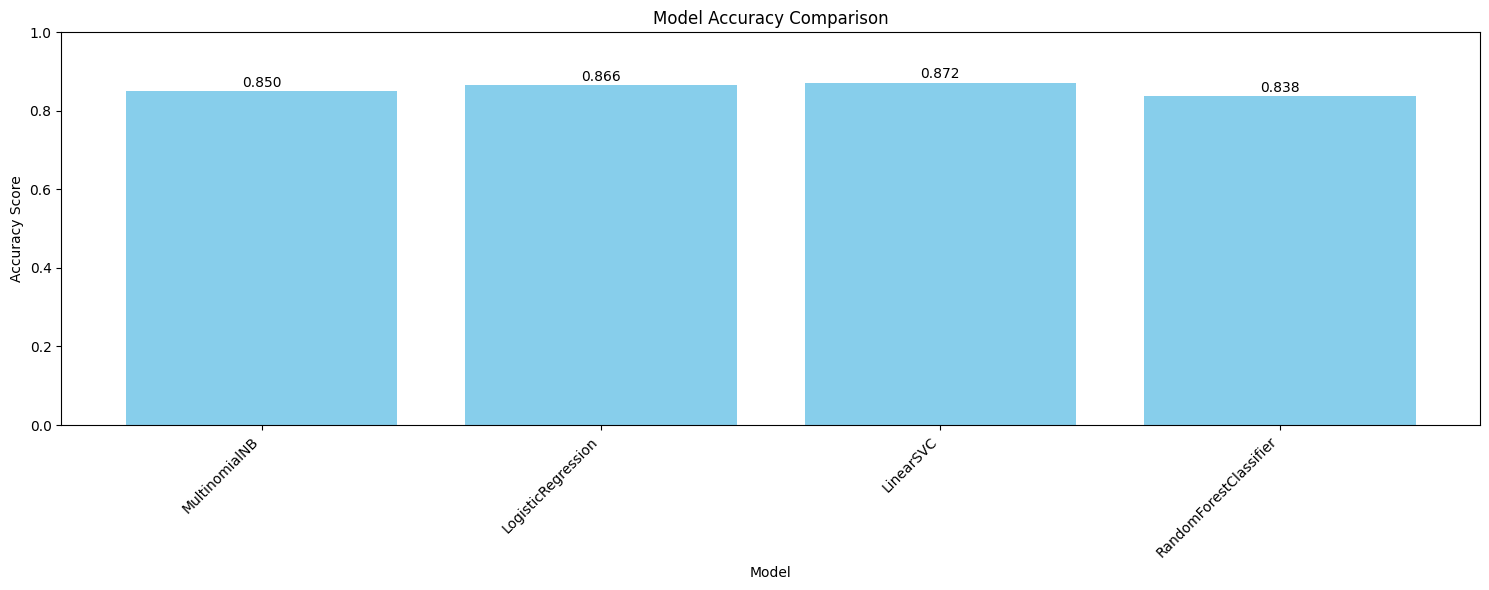

In [34]:
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.figure(figsize=(15, 6))
bars = plt.bar(models, accuracies, color='skyblue')
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.3f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords='offset points', ha='center', fontsize=10)

plt.tight_layout()
plt.show()